# Neural Network Pytorch MLP

Vogliamo modellare un multi-layer perceptron utilizzando **Pytorch** per classificare il dataset MNIST.

In [13]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

Using PyTorch version: 0.4.1.post2 CUDA: False


## Dati
Vogliamo utilizzare il dataset MNIST, si può scaricare direttamente o caricarlo dai documenti.

In [14]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

validation_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)

Vogliamo ora estrarre le prime tre classi in modo da fare il train solo su queste.

In [15]:
tl = train_loader.dataset.train_labels
td = train_loader.dataset.train_data

zeros = td[tl == 0]
ones = td[tl == 1]
twos = td[tl == 2]

data012 = torch.cat([zeros, ones, twos])
labels012 = torch.cat([torch.zeros((len(zeros), 1)), torch.ones((len(ones), 1)), 2.0*torch.ones((len(twos), 1))])

Adesso creiamo un nuovo dataset per il train in modo da vedere come reagisce il classificatore.

In [16]:
vl = validation_loader.dataset.test_labels
vd = validation_loader.dataset.test_data

threes = vd[vl == 3]
fours = vd[vl == 4]
fives = vd[vl == 5]

data345 = torch.cat([threes, fours, fives])
#labels345 = torch.cat([torch.threes((len(threes), 1)), torch.fours((len(fours), 1)), 2.0*torch.fours((len(fives), 1))])

Adesso possiamo utilizzare i nuovi dataset creati per train e test.

In [41]:
train_loader012 = torch.utils.data.DataLoader(data012, batch_size=batch_size, shuffle=True, **kwargs)

validation_loader345 = torch.utils.data.DataLoader(data345, batch_size=batch_size, shuffle=True, **kwargs)

In [42]:
for X_train in train_loader012:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    #print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 28, 28]) type: torch.ByteTensor


proviamo a stampare le prime 10 immagini del train:

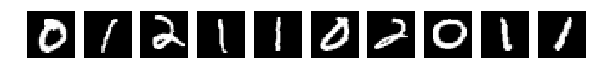

In [43]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :].numpy().reshape(28,28), cmap="gray")

proviamo a stampare le prime 10 immagini del test:

In [44]:
for Y_train in validation_loader345:
    print('Y_train:', Y_train.size(), 'type:', Y_train.type())
    break

Y_train: torch.Size([32, 28, 28]) type: torch.ByteTensor


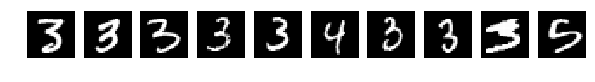

In [45]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(Y_train[i, :, :].numpy().reshape(28,28), cmap="gray")

## Multi-layer Perceptron
Definiamo ora la rete neurale come una Python class.

In [46]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 128)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), 1)

model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.2)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc2_drop): Dropout(p=0.2)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


Definiamo le funzioni di **train** e **test**

In [47]:
def train(epoch, log_interval=100):
    model.train()
    batch_idx = 0
    while(batch_idx != batch_size):
        for (data, target) in enumerate(train_loader012):
            print (train_loader012)
            if cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader012.dataset),
                    100. * batch_idx / len(train_loader012), loss.item()))
            batch_idx = batch_idx +1

In [48]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader345:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader345)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader345.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader345.dataset), accuracy))

Possiamo adesso addestrare il nostro modello, ogni epoca passa attraverso tutto il dataset del train. Dopo ogni epoca valutiamo il modello attraverso il test(). L'obiettivo è verificare che il modello riconosce come 0, 1, 2 anche le immagini di 3, 4, 5 quindi la classificazione è **out of distribution**

In [38]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

TypeError: Variable data has to be a tensor, but got int